## Accessing Esri 10m Land Use/Land Cover (9-class) data with the Planetary Computer STAC API

This dataset contains global estimates of 10-class land use/land cover for 2017 - 2019, derived from ESA Sentinel-2 imagery at 10m resolution. In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from dask.distributed import Client as dask_client
from matplotlib.colors import ListedColormap
from pystac_client import Client

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer as pc
import rasterio
import rasterio.features
import stackstac

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Select a region and find data items

We'll pick an area in Thailand and use the STAC API to find what data items are avaialable.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [100.08682250976562, 13.755392488822052],
            [100.33538818359375, 13.755392488822052],
            [100.33538818359375, 13.98604363871656],
            [100.08682250976562, 13.98604363871656],
            [100.08682250976562, 13.755392488822052],
        ]
    ],
}

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(collections=["io-lulc-9-class"], intersects=area_of_interest)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 3 Items


In [4]:
items

[<Item id=47P-2019>, <Item id=47P-2018>, <Item id=47P-2017>]

We found three items that intersect with our area of interest, one per year.

We'll use the [stackstac](https://stackstac.readthedocs.io/en/latest/) library to read all of these into a single `xarray.DataArray`.

In [5]:
# The STAC metadata contains some information we'll want to use when creating
# our merged dataset. Get the EPSG code of the first item and the nodata value.
item = items[0]
signed_items = [pc.sign(item).to_dict() for item in items]
bounds_latlon = rasterio.features.bounds(area_of_interest)

# Create a single DataArray from out multiple resutls with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = stackstac.stack(
    signed_items,
    dtype=np.ubyte,
    fill_value=255,
    bounds_latlon=bounds_latlon,
)

stack

<xarray.DataArray 'stackstac-920cbaf6d3709c6de8e9bfdd6c4d3331' (time: 3, band: 1, y: 2566, x: 2700)>
dask.array<fetch_raster_window, shape=(3, 1, 2566, 2700), dtype=uint8, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[ns] 2017-06-01 2018-06-01 2019-06-01
    id               (time) <U8 '47P-2017' '47P-2018' '47P-2019'
  * band             (band) <U4 'data'
  * x                (x) float64 6.174e+05 6.174e+05 ... 6.444e+05 6.444e+05
  * y                (y) float64 1.547e+06 1.547e+06 ... 1.521e+06 1.521e+06
    io:supercell_id  <U3 '47P'
    proj:shape       object {66148, 88695}
    proj:transform   object {0.0, 10.0, 169263.29477130197, 1771251.183211173...
    proj:bbox        object {1771251.1832111736, 830743.294771302, 884301.183...
    io:tile_id       <U3 '47P'
    proj:epsg        int64 32647
    end_datetime     (time) <U20 '2018-01-01T00:00:00Z' ... '2020-01-01T00:00...
    start_datetime   (time) <U20 '2017-01-01T00:00:00Z' ... '2019-01-01T00:00...
    raster:bands     object {'nodata': 0, 'spatial_resolution': 10}
    epsg             int64 32647
Attributes:
    spec:        RasterSpec(epsg=32647, bounds=(617380.0, 1520930.0, 644380.0...
    crs:         epsg:32647
    transform:   | 10.00, 0.00, 617380.00|\n| 0.00,-10.00, 1546590.00|\n| 0.0...
    resolution:  10.0

Start up a local Dask cluster to allow us to do parallel reads. Use the following URL to open a dashboard in the Hub's Dask Extension. 

In [6]:
client = dask_client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [7]:
stack

<xarray.DataArray 'stackstac-920cbaf6d3709c6de8e9bfdd6c4d3331' (time: 3, band: 1, y: 2566, x: 2700)>
dask.array<fetch_raster_window, shape=(3, 1, 2566, 2700), dtype=uint8, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[ns] 2017-06-01 2018-06-01 2019-06-01
    id               (time) <U8 '47P-2017' '47P-2018' '47P-2019'
  * band             (band) <U4 'data'
  * x                (x) float64 6.174e+05 6.174e+05 ... 6.444e+05 6.444e+05
  * y                (y) float64 1.547e+06 1.547e+06 ... 1.521e+06 1.521e+06
    io:supercell_id  <U3 '47P'
    proj:shape       object {66148, 88695}
    proj:transform   object {0.0, 10.0, 169263.29477130197, 1771251.183211173...
    proj:bbox        object {1771251.1832111736, 830743.294771302, 884301.183...
    io:tile_id       <U3 '47P'
    proj:epsg        int64 32647
    end_datetime     (time) <U20 '2018-01-01T00:00:00Z' ... '2020-01-01T00:00...
    start_datetime   (time) <U20 '2017-01-01T00:00:00Z' ... '2019-01-01T00:00...
    raster:bands     object {'nodata': 0, 'spatial_resolution': 10}
    epsg             int64 32647
Attributes:
    spec:        RasterSpec(epsg=32647, bounds=(617380.0, 1520930.0, 644380.0...
    crs:         epsg:32647
    transform:   | 10.00, 0.00, 617380.00|\n| 0.00,-10.00, 1546590.00|\n| 0.0...
    resolution:  10.0

### Mosaic and clip the raster

So far, we haven't read in any data. Stackstac has used the STAC metadata to construct a DataArray that will contain our Item data. Let's mosaic the rasters across the `time` dimension (remember, they're all from a single synthesized "time" from 2020) and drop the single `band` dimension. Finally, we ask Dask to read the actual data by calling `.compute()`.

In [8]:
# merged = stack.groupby("time").apply(stackstac.mosaic).compute()
merged = stack.squeeze().compute()

Now a quick plot to check that we've got the data we want.

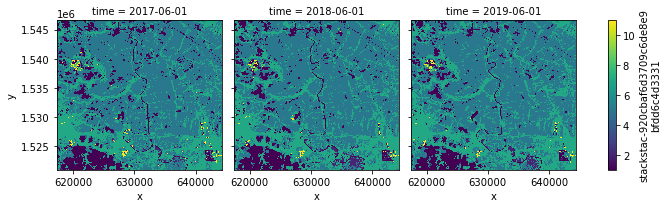

In [9]:
merged.plot(col="time")
plt.show()

It looks good, but it doesn't look like a land cover map. The source GeoTIFFs contain a colormap and the STAC metadata contains the class names. We'll open one of the source files just to read this metadata and construct the right colors and names for our plot.

In [10]:
from pystac.extensions.item_assets import ItemAssetsExtension

collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)
class_names

{'No Data': 0,
 'Water': 1,
 'Trees': 2,
 'Flooded vegetation': 4,
 'Crops': 5,
 'Built area': 7,
 'Bare ground': 8,
 'Snow/ice': 9,
 'Clouds': 10,
 'Rangeland': 11}

In [11]:
with rasterio.open(pc.sign(item.assets["data"].href)) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max(class_names.values()))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

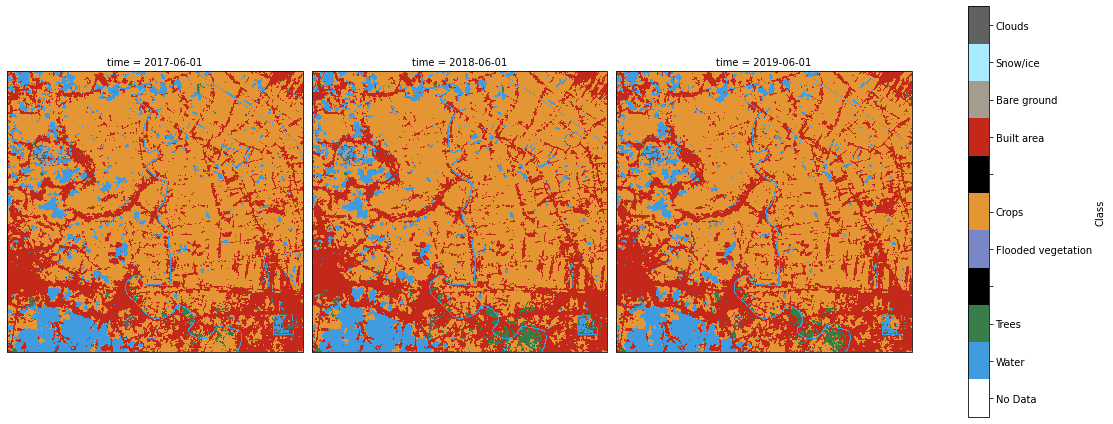

In [12]:
vmin = 0
vmax = max(class_names.values())
epsg = merged.epsg.item()

p = merged.plot(
    subplot_kws=dict(projection=ccrs.epsg(epsg)),
    col="time",
    transform=ccrs.epsg(epsg),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    figsize=(16, 6),
)
ticks = np.linspace(0.5, 10.5, 11)
labels = [values_to_classes.get(i, "") for i in range(cmap.N)]
p.cbar.set_ticks(ticks, labels=labels)
p.cbar.set_label("Class")

That looks better. Let's also plot a histogram of the pixel values to see the distribution of land cover types within our area of interest. We can reuse the colormap we generated to help tie the two visualizations together.

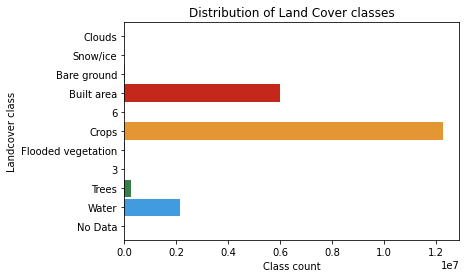

In [13]:
colors = list(cmap.colors)

ax = (
    pd.value_counts(merged.data.ravel(), sort=False)
    .sort_index()
    .reindex(range(cmap.N), fill_value=0)
    .rename(values_to_classes)
    .plot.barh(color=colors, rot=0, width=0.9)
)
ax.set(
    title="Distribution of Land Cover classes",
    ylabel="Landcover class",
    xlabel="Class count",
);

We can make a similar plot per year.

In [14]:
df = merged.stack(pixel=("y", "x")).T.to_pandas()

counts = (
    df.stack()
    .rename("class")
    .reset_index()
    .groupby("time")["class"]
    .value_counts()
    .nlargest(9)
    .rename("count")
    .swaplevel()
    .sort_index(ascending=False)
    .rename(lambda x: x.year, level="time")
)

colors = cmap(counts.index.get_level_values("class") / cmap.N)

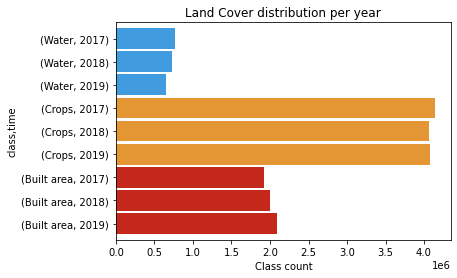

In [15]:
ax = counts.rename(values_to_classes, level="class").plot.barh(color=colors, width=0.9)
ax.set(xlabel="Class count", title="Land Cover distribution per year");

Finally, we can plot the transitions between years, to show which classes are transitioning to which other classes:

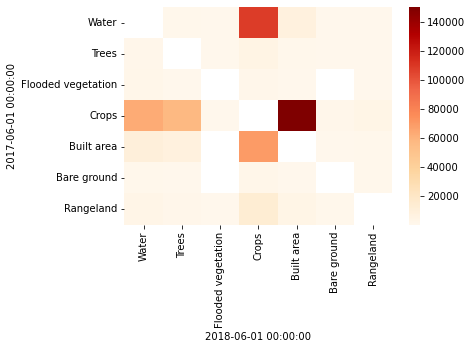

In [16]:
import seaborn as sns

by_year = df.groupby("2017-06-01")["2018-06-01"].value_counts()

years = by_year.index.levels[0]
classes = by_year.index.levels[1]

idx = pd.MultiIndex.from_product([years, classes])
transitions = by_year.reindex(idx, fill_value=0)
by_year[by_year.index.get_level_values(0) == by_year.index.get_level_values(1)] = np.nan

transitions = by_year.unstack().rename(
    columns=values_to_classes, index=values_to_classes
)

sns.heatmap(transitions, cmap="OrRd");

Areas transition from the label on the vertical axis to the label on the horizontal axis. So there's a relatively high number of transitions from "Crops" to "Built area" (ignoring areas that don't change at all).